In [10]:
import numpy as np
from numpy import pi
from scipy import linalg as la
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
# Some rotation utility functions

def calculate_rotation_matrix(n,sin,cos):
    '''
    Rotatation matrix around a normal vector n
    By angle theta, passed in as <sin> = sin(theta) and
    <cos> = cos(theta)
    '''
    assert np.abs(la.norm(n) - 1) < 1e-3, 'n must be a unit vector'
    
    n1 = n[0]
    n2 = n[1]
    n3 = n[2]
#     cos = np.sqrt(1-sin**2)
    R = np.zeros((3,3))
    R[0,0] = cos + n1**2 * (1-cos)
    R[0,1] = n1*n2*(1-cos) - n3*sin
    R[0,2] = n1*n3*(1-cos) + n2*sin
    R[1,0] = n1*n2*(1-cos) + n3*sin
    R[1,1] = cos + n2**2 * (1-cos)
    R[1,2] = n2*n3*(1-cos) - n1*sin
    R[2,0] = n1*n3*(1-cos) - n2*sin
    R[2,1] = n2*n3*(1-cos) + n1*sin
    R[2,2] = cos + n3**2 * (1-cos)
    
    return R

def rotate_to_z(v):
    '''
    Takes a vector v and rotates it to be aligned with the z axis
    '''
    normv = la.norm(v)
    v = v / normv
    z = np.array([0,0,1])
    # normal vector between v and z
    n = np.cross(v,z)
    # sin of angle by which to rotate
    sin = la.norm(n)
    cos = np.dot(v,z)
    n = n / sin
    R = calculate_rotation_matrix(n,sin,cos)
    vz = R @ v * normv
    return vz,n,sin

def rotate_z_to_v(z_noisy,v):
    '''
    Takes vector z_noisy and rotates it according to the same rotation
    that would align z with v
    '''
    z = np.array([0,0,1])
    n = np.cross(z,v)
    sin = la.norm(n)
    n = n / sin
    cos = np.dot(z,v)
    R = calculate_rotation_matrix(n,sin,cos)
    v_noisy = R @ z_noisy
    return v_noisy
    

In [16]:
def skew_symm(x):
    Sx = np.zeros((2,3))
    Sx[0,1] = -x[2]
    Sx[0,2] = x[1]
    Sx[1,0] = x[2]
    Sx[1,2] = -x[1]
    return Sx

In [8]:
def plot_pointing_vectors(ax, S, V):
    _,N = V.shape
    for i in range(N):
        # get endpoints
        ep1 = S[:,i]
        l = la.norm(ep1)*1.5
        ep2 = ep1 + l * V[:,i]
        ax.plot((ep1[0],ep2[0]),(ep1[1],ep2[1]),(ep1[2],ep2[2]),linewidth=1,zorder=-1)
        ax.scatter(S[0,:],S[1,:],S[2,:],c = 'm')

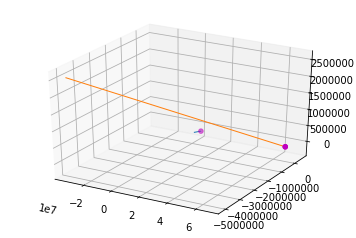

In [11]:
# event_dict = {'event1':{'sensor_pointing': [-0.9984, 0.0499, -0.025],
#                        'sensor_position': [6800000,-2e4,0],
#                        'major_axis_direction': [0,0,0],
#                        'minor_axis_direction':[0,0,0],
#                        'major_axis_length': 2e4,
#                        'minor_axis_length': 1e4
#                       },
#              'event2':{'sensor_pointing':[-.9984, -0.0499, 0.025],
#                        'sensor_position':[6800000,2e4,0],
#                        'major_axis_direction': [0,0,0],
#                        'minor_axis_direction':[0,0,0],
#                        'major_axis_length': 2e4,
#                        'minor_axis_length': 1e4
#                       }
#             }
S = np.array([[6800000,-2e4,0],[68000000,2e4,0]]).T
V = np.array([[-0.9984, 0.0499, -0.025],[-.9984, -0.0499, 0.025]]).T

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plot_pointing_vectors(ax,S,V)

In [45]:
def distribute_sensors(n_sensors,lb=5,ub=15):
    '''
    distribute the sensors in a hollowed sphere
    '''
    r = np.random.uniform(lb,ub,n_sensors)
    theta = np.random.uniform(0,np.pi,n_sensors)
    phi = np.random.uniform(0,2*np.pi,n_sensors)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    S = np.vstack((x,y,z))
    return S

def sensor_proj(S):
    '''
    calculate projection matrices for the sensors
    NOTE: Should this be done using V (noisy) instead of S (not noisy)?
    '''
    _,n_sensors = S.shape
    P = np.zeros((3,4,n_sensors))
    for i in range(n_sensors):
        p = S[:,i]
        tmpn = np.cross([0,0,1],p)
        tmpn /= la.norm(tmpn)
        up = np.cross(p,tmpn)
        up /= la.norm(up)
        
        L = -p / la.norm(p)
        tmpa = np.cross(L,up)
        tmpa /= la.norm(tmpa)
        tmpb = np.cross(tmpa,L)
        R = np.r_[tmpa,tmpb,-L].reshape((3,3))
        T = -R @ p
        P[:,:,i] = np.c_[R,T]
    return P
        

def form_V(S, a=np.array([1,0,0]),b=np.array([0,1,0]),sig_a=0,sig_b=0):
    S_norm = la.norm(S,axis=0)
    V = -S / S_norm
    V = add_noise(a,b,sig_a,sig_b,V)
    return V
    
def form_G(S,V):
    '''
    Helper function for least squares triangulation
    G is the geometry matrix
    V1 is a matrix of unit pointing vectors
    '''
    _,n = S.shape
    I = np.tile(np.eye(3),(n,1))
    S_norm = la.norm(S,axis=0)
    V_temp = np.tile(V,(n,1))
    id_temp = np.kron(np.eye(n),np.ones((3,1)))
    V2 = V_temp * id_temp
    G = np.c_[I,V2]
    return G

def form_G_noisy(S,a=np.array([1,0,0]),b=np.array([0,1,0]),sig_a=0,sig_b=0):
    '''
    Helper function for least squares triangulation
    G is the geometry matrix
    V1 is a matrix of unit pointing vectors
    '''
    _,n = S.shape
    I = np.tile(np.eye(3),(n,1))
    S_norm = la.norm(S,axis=0)
    V1 = -S / S_norm
    V1 = add_noise(a,b,sig_a,sig_b,V1)
    V2 = np.tile(V1,(n,1))
    id_temp = np.kron(np.eye(n),np.ones((3,1)))
    V = V2 * id_temp
    G = np.c_[I,V]
    return G,V1

def add_noise(a, b, sig_a, sig_b, V):
    '''
    Add noise to V along axes a, b
    Characterized by standard deviations sig_a, sig_b
    Assuming that noise is white
    For the nth sensor, assume that z points in the direction of v_n
    y is positive in the camera-up direction
    x is positive such that x cross y = z (will be in the left direction)
    a and b should be orthogonal
    '''
    assert np.dot(a,b) < 1e-3, "a and b must be orthogonal"
    _,N = V.shape
    V_noisy = np.zeros_like(V)
    z = np.array([0,0,1])
    # normal vectors for rotation
    n_a = np.cross(z,a)
    n_b = np.cross(z,b)
    for i in range(N):
        # randomly perturb z along a, b
        theta_a = np.random.normal(0,sig_a,1)
        R_a = calculate_rotation_matrix(n_a,np.sin(theta_a),np.cos(theta_a))
        theta_b = np.random.normal(0,sig_b,1)
        R_b = calculate_rotation_matrix(n_b,np.sin(theta_b),np.cos(theta_b))
        z_noisy = R_a @ R_b @ z
        
        v = V[:,i]
        assert np.abs(la.norm(v) - 1) <= 1e-3, "V must be composed of unit column vectors"
        V_noisy[:,i] = rotate_z_to_v(z_noisy, v)
    
    return V_noisy

In [35]:
V = np.array([[-1,0,0],[0,-1,0]]).T
add_noise(a,b,sig_a,sig_b,V)

[0.02652045]
[-0.06414571]
[ 0.0264628  -0.06410172  0.99759245]
[-0.99759245 -0.06410172  0.0264628 ]
[0 0 0]
[-0.0473714]
[-0.02152992]
[-0.04734271 -0.02152826  0.99864669]
[-0.04734271 -0.99864669 -0.02152826]
[0 0 0]


array([[0, 0],
       [0, 0],
       [0, 0]])

In [25]:
v = np.array([-1,0,0]) # corresponds to sensor along pos x axis
a = np.array([1,0,0])
b = np.array([0,1,0])
sig_a = 0.1
sig_b = 0.1

z = np.array([0,0,1])
theta_a = 0.05
theta_b = 0.05
n_a = np.cross(z,a)
n_b = np.cross(z,b)
R_a = calculate_rotation_matrix(n_a,np.sin(theta_a),np.cos(theta_a))
R_b = calculate_rotation_matrix(n_b,np.sin(theta_b),np.cos(theta_b))
z_a = R_a @ z
z_b = R_b @ z
print(z_a)
print(z_b)
print(rotate_z_to_v(z_a,v))
print(rotate_z_to_v(z_b,v))
print(rotate_z_to_v(a,v))
print(rotate_z_to_v(b,v))

[0.04997917 0.         0.99875026]
[0.         0.04997917 0.99875026]
[-0.99875026  0.          0.04997917]
[-0.99875026  0.04997917  0.        ]
[0. 0. 1.]
[0. 1. 0.]


In [6]:
def ls_triangulate(S,V):
    _,n = S.shape
    G = form_G(S,V)
    r0 = np.reshape(S.T,(3*n,1))
    rt,_,_,_ = la.lstsq(G,r0)
    rt = rt.flatten()
    r = rt[:3]
    t = rt[3:]
    return r,t

def ls_triangulate_fullsim(S,a=np.array([1,0,0]),b=np.array([0,1,0]),sig_a=0,sig_b=0):
    _,n = S.shape
    V = form_V(S,a,b,sig_a,sig_b)
    G = form_G(S,V)
    
    r0 = np.reshape(S.T,(3*n,1))
    rt,_,_,_ = la.lstsq(G,r0)
    rt = rt.flatten()
    r = rt[:3]
    t = rt[3:]
    return r,t

## 15 sensor simulation

In [7]:
tgt = np.zeros(3)
n_sensors = 15
S = distribute_sensors(n_sensors,10,15)

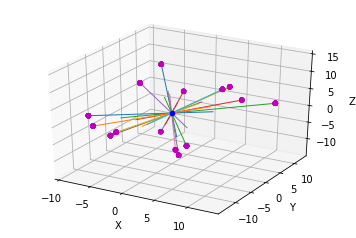

In [8]:
V = form_V(S)
G = form_G(S,V)

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plot_pointing_vectors(ax,S,V)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(tgt[0],tgt[1],tgt[2],c='b')
plt.show()

Noisy case, LS solution

Estimated coordinates: [ 0.13818275  0.41459852 -0.56399808]
MSE: 0.509080234475449


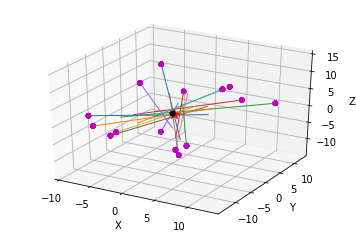

In [9]:
V = form_V(S,sig_a=.1,sig_b=.05)
est,_ = ls_triangulate(S,V)
mse = la.norm(est-tgt)**2
print('Estimated coordinates:',est)
print('MSE:',mse)
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plot_pointing_vectors(ax,S,V)
ax.scatter(tgt[0],tgt[1],tgt[2],c='k',s=25,zorder=0)
ax.scatter(est[0],est[1],est[2],c='r',marker='*',s=100,zorder=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

Estimated coordinates: [-0.18844772  1.18010143  0.4864818 ]
MSE: 1.6648164735092568


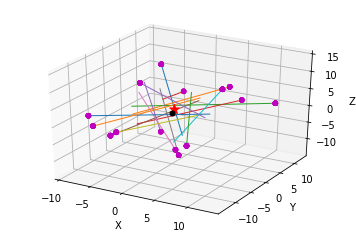

In [11]:
V = form_V(S,sig_a=.15,sig_b=.15)
est,_ = ls_triangulate(S,V)
mse = la.norm(est-tgt)**2
print('Estimated coordinates:',est)
print('MSE:',mse)
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plot_pointing_vectors(ax,S,V)
ax.scatter(tgt[0],tgt[1],tgt[2],c='k',s=25,zorder=0)
ax.scatter(est[0],est[1],est[2],c='r',marker='*',s=100,zorder=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## Writing the Kalman Solution 
(which will be handled iteratively)

In [88]:
def calculate_ellipse_covariance(s,a,b,sig_a,sig_b):
    '''
    Finds covariance matrix of pointing vector error ellipse in world coordinates
    Takes in a,b which are major and minor error axes in camera coordinates
    sig_a,sig_b which are error variances 
    v, which is the pointing vector of the camera
    '''
    # First, construct matrix of left eigenvectors in camera coordinates
    # based on given error ellipse
    # Use the fact that a,b are eigenvectors and var_a,var_b are eigenvalues
    var_a = sig_a**2
    var_b = sig_b**2
    z_c = np.array([0,0,1])
    U_c = np.vstack((a,b,z_c)).T
    L = np.diag(np.array([var_a,var_b,0]))
    
    # Rotate U to be in the world coordinates
    v = -s / la.norm(s)
    n_w = np.cross(z_c,v)
    sin_theta_w = la.norm(n_w)
    n_w = n_w / sin_theta_w
    cos_theta_w = np.dot(z_c,v)
    R = calculate_rotation_matrix(n_w,sin_theta_w,cos_theta_w)
#     U_w = R_theta_w @ U_c # U_w is orthonormal so inv(U) = U.T
#     print(U_w)
    return R @ L @ la.pinv(R)
    
#     return U_w @ L @ U_w.T

def calculate_ellipsoid_covariance(s1,s2,a1,a2,b1,b2,sig_a1,sig_a2,sig_b1,sig_b2,X):
    '''
    Finds covariance matrix of error ellipsoid for calculating triangulation
    given two sensors
    Takes in a,b which are major and minor error axes in camera coordinates
    sig_a,sig_b which are error variances 
    '''
    C1 = np.diag([sig_a1,sig_b1,0])
    C2 = np.diag([sig_a2,sig_b2,0])
    Cmid = np.block([[C1,np.zeros((3,3))],[np.zeros((3,3)),C2]])
    
    S = np.vstack((s1,s2)).T
    P = sensor_proj(S)
    P1 = P[:,:,0]
    P2 = P[:,:,1]
    
    ## TODO: do we need to use the projections here?
    x = np.array([0,0,1]) # supposedly each camera images in the center
#     X = np.array([[0,0,0,1]]) # target is at the origin
    X = np.array([[X[0],X[1],X[2],1]])
    Sx = skew_symm(x)
    A = np.vstack(((Sx @ P1), (Sx @ P2)))
    
    P1X = P1 @ X.T
    P1X /= P1X[2]
    P2X = P2 @ X.T
    P2X /= P2X[2]
    
    B = np.block([[-skew_symm(P1X),np.zeros((2,3))],[np.zeros((2,3)),-skew_symm(P2X)]])
    
    N_ul = A.T @ la.pinv( B @ Cmid @ B.T ) @ A
    N = np.block([[N_ul,X.T],[X,0]])
    return la.pinv(N)[:4,:4]

In [42]:
s1 = np.array([1.0,0.0,0.0])
s2 = np.array([0.0,1.0,0.0])
a = np.array([1,0,0])
b = np.array([0,1,0])
sig_a = .1
sig_b = .1
C1 = calculate_ellipse_covariance(s1,a,b,sig_a,sig_b)
C2 = calculate_ellipse_covariance(s2,a,b,sig_a,sig_b)
C = calculate_ellipsoid_covariance(s1,s2,a,a,b,b,sig_a,sig_a,sig_b,sig_b)
print(C1)
print(C2)
print(C)

[[0.   0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.01]]
[[0.01 0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.01]]
[[0.1  0.   0.   0.  ]
 [0.   0.1  0.   0.  ]
 [0.   0.   0.05 0.  ]
 [0.   0.   0.   0.  ]]


In [79]:
def kalman_simple(S,V,a=np.array([1,0,0]),b=np.array([0,1,0]),sig_a=0,sig_b=0):
    '''
    Assumes same error model for every sensor
    '''
    _,n = S.shape
    covars = np.zeros((3,3,n))
    ests = np.zeros((3,n))
    mse = np.zeros(n)
    
    for i in range(n):
        s1 = S[:,i]
        s2 = S[:,i-1]
        
        # Triangulate between consecutive pairs
        S_tmp = np.vstack((s1,s2)).T
        v1 = V[:,i]
        v2 = V[:,i-1]
        V_tmp = np.vstack((v1,v2)).T
        X,_ = ls_triangulate(S_tmp,V_tmp)
        ests[:,i] = X
        
        # Covariance ellipsoid for the triangulation
        C = calculate_ellipsoid_covariance(s1,s2,a,a,b,b,sig_a,sig_a,sig_b,sig_b,X)
        covars[:,:,i] = C[:3,:3]
        
        
    # Kalman fusion
    # Just get the x coordinate for now
    y = ests[:,0] # initialize y, our solution
    C_y = covars[:,:,0] # initialize solution covariance
    mse[0] = la.norm(y)**2/3
    for j in range(1,n):
        x1 = y
        x2 = ests[:,j]
        C1 = C_y
        C2 = covars[:,:,j]
        K = C1 @ la.pinv(C1 + C2) # Kalman gain
        y = x1 + K @ (x2 - x1)
        mse[j] = la.norm(y)**2 / 3
        C_y = (np.eye(3) - K) @ C1
#         print('---------------------')
#         print('Iteration', j)
#         print('---------------------')
#         print('x1 = ', x1)
#         print('x2 = ', x2)
#         print('K = ', K)
#         print('Difference = ', x2 - x1)
#         print('Update = ', K @ (x2 - x1))
#         print('y = ', y)
#         print('MSE = ', mse[j])
        
    return y, C_y, mse
        

In [95]:
tgt = np.zeros(3)
n_sensors = 10
S = distribute_sensors(n_sensors,15,25)

# Noise characteristics
a = np.array([1,0,0])
b = np.array([0,1,0])
sig_a = .1
sig_b = .2

V = form_V(S,a,b,sig_a,sig_b)

y,_,mse = kalman_simple(S,V,a,b,sig_a,sig_b)
print('Kalman Solution:', y)
print('Kalman MSE:', mse[-1])
est,_ = ls_triangulate(S,V)
print('Least Squares Solution:', est)
lstsq_mse = la.norm(est)**2 / 3
print('Least Squares MSE:', lstsq_mse)

Kalman Solution: [-0.02375874  0.44329232 -0.41937386]
Kalman MSE: 0.12431566503142237
Least Squares Solution: [-1.15590726  1.20065083 -0.99072316]
Least Squares MSE: 1.253072126377799


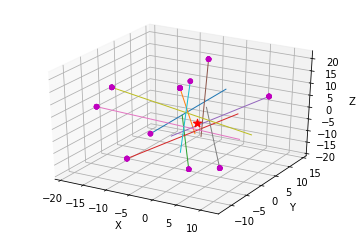

In [96]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plot_pointing_vectors(ax,S,V)
ax.scatter(tgt[0],tgt[1],tgt[2],c='r',s=75,marker='*',zorder=0)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

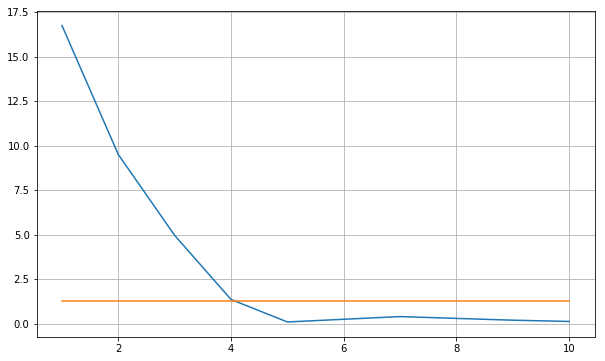

In [97]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(np.linspace(1,n_sensors,n_sensors),mse)
ax.plot([1,n_sensors],[lstsq_mse,lstsq_mse])
ax.axis('tight')
ax.grid(True)

In [98]:
tgt = np.zeros(3)
n_sensors = 5
S = distribute_sensors(n_sensors,15,25)

# Noise characteristics
a = np.array([1,0,0])
b = np.array([0,1,0])
sig_a = .1
sig_b = .2

V = form_V(S,a,b,sig_a,sig_b)

y,_,mse = kalman_simple(S,V,a,b,sig_a,sig_b)
print('Kalman Solution:', y)
print('Kalman MSE:', mse[-1])
est,_ = ls_triangulate(S,V)
print('Least Squares Solution:', est)
lstsq_mse = la.norm(est)**2 / 3
print('Least Squares MSE:', lstsq_mse)

Kalman Solution: [-2.11983218 -0.3897102   0.13588592]
Kalman MSE: 1.5546758279106723
Least Squares Solution: [-2.75646143  0.38445838  0.30753703]
Least Squares MSE: 2.613488968906956


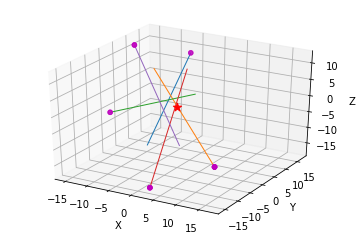

In [99]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plot_pointing_vectors(ax,S,V)
ax.scatter(tgt[0],tgt[1],tgt[2],c='r',s=75,marker='*',zorder=0)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

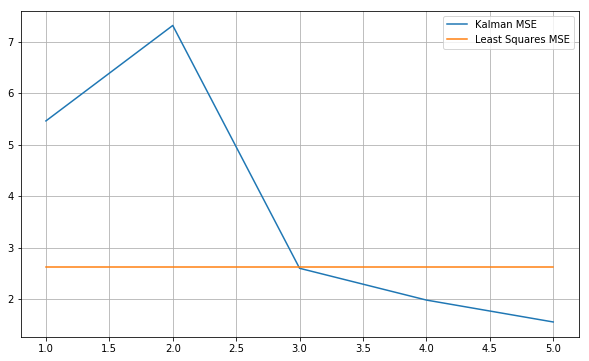

In [100]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(np.linspace(1,n_sensors,n_sensors),mse,label='Kalman MSE')
ax.plot([1,n_sensors],[lstsq_mse,lstsq_mse],label='Least Squares MSE')
ax.axis('tight')
ax.grid(True)
ax.legend()

In [101]:
tgt = np.zeros(3)
n_sensors = 5
S = distribute_sensors(n_sensors,15,25)

# Noise characteristics
a = np.array([1,0,0])
b = np.array([0,1,0])
sig_a = .1
sig_b = .2

V = form_V(S,a,b,sig_a,sig_b)

y,_,mse = kalman_simple(S,V,a,b,sig_a,sig_b)
print('Kalman Solution:', y)
print('Kalman MSE:', mse[-1])
est,_ = ls_triangulate(S,V)
print('Least Squares Solution:', est)
lstsq_mse = la.norm(est)**2 / 3
print('Least Squares MSE:', lstsq_mse)

Kalman Solution: [ 4.07703955  0.08458915 -1.15530877]
Kalman MSE: 5.988048394530551
Least Squares Solution: [ 3.76111323 -0.21662261 -1.11726697]
Least Squares MSE: 5.147061181509151


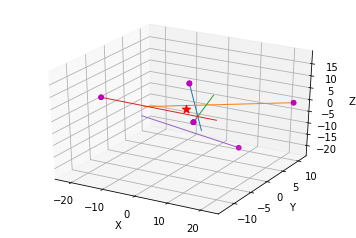

In [102]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plot_pointing_vectors(ax,S,V)
ax.scatter(tgt[0],tgt[1],tgt[2],c='r',s=75,marker='*',zorder=0)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

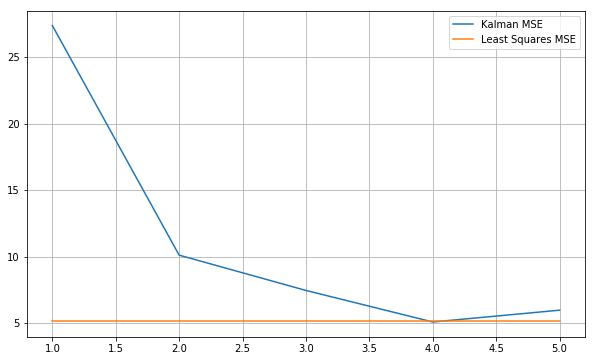

In [103]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(np.linspace(1,n_sensors,n_sensors),mse,label='Kalman MSE')
ax.plot([1,n_sensors],[lstsq_mse,lstsq_mse],label='Least Squares MSE')
ax.axis('tight')
ax.grid(True)
ax.legend()

Kalman Solution: [ 17.3448183  -11.54067088  -5.02590712]
Kalman MSE: 153.09651618081594
Least Squares Solution: [ 11.39086206 -15.71213805  -5.55383525]
Least Squares MSE: 135.82270218402536


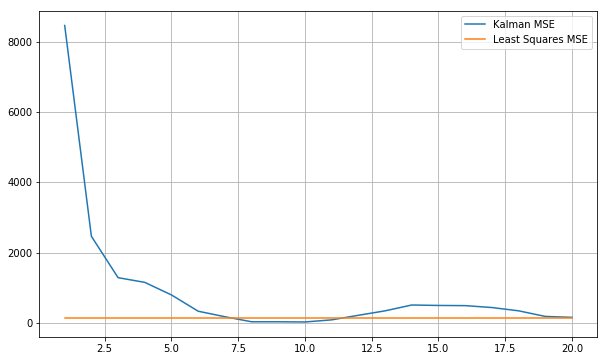

In [135]:
tgt = np.zeros(3)
n_sensors = 20
S = distribute_sensors(n_sensors,3e6,3.1e6)

# Noise characteristics
a = np.array([1,0,0])
b = np.array([0,1,0])
sig_a = 37e-6
sig_b = 10e-6

V = form_V(S,a,b,sig_a,sig_b)

y,_,mse = kalman_simple(S,V,a,b,sig_a,sig_b)
print('Kalman Solution:', y)
print('Kalman MSE:', mse[-1])
est,_ = ls_triangulate(S,V)
print('Least Squares Solution:', est)
lstsq_mse = la.norm(est)**2 / 3
print('Least Squares MSE:', lstsq_mse)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(np.linspace(1,n_sensors,n_sensors),mse,label='Kalman MSE')
ax.plot([1,n_sensors],[lstsq_mse,lstsq_mse],label='Least Squares MSE')
ax.axis('tight')
ax.grid(True)
ax.legend()

In [140]:
def kalman_simple_recalc(S,V,a=np.array([1,0,0]),b=np.array([0,1,0]),sig_a=0,sig_b=0):
    '''
    Assumes same error model for every sensor
    '''
    _,n = S.shape
    mse = np.zeros(n)
    
    # first estimate
    s1 = S[:,0]
    s2 = S[:,-1]
    S_tmp = np.vstack((s1,s2)).T
    v1 = V[:,0]
    v2 = V[:,-1]
    V_tmp = np.vstack((v1,v2)).T
    y,_ = ls_triangulate(S_tmp,V_tmp)
    C_y = calculate_ellipsoid_covariance(s1,s2,a,a,b,b,sig_a,sig_a,sig_b,sig_b,y)[:3,:3]
        
    # Kalman fusion
    mse[0] = la.norm(y)**2/3
    for j in range(1,n):
        x1 = y
        s1 = S[:,j]
        s2 = S[:,j-1]
        S_tmp = np.vstack((s1,s2)).T
        v1 = V[:,j]
        v2 = (x1 - s2) / la.norm(x1 - s2)
        V_tmp = np.vstack((v1,v2)).T
        x2,_ = ls_triangulate(S_tmp,V_tmp)
        C1 = C_y
        C2 = calculate_ellipsoid_covariance(s1,s2,a,a,b,b,sig_a,sig_a,sig_b,sig_b,x2)[:3,:3]
        
        K = C1 @ la.pinv(C1 + C2) # Kalman gain
        y = x1 + K @ (x2 - x1)
        mse[j] = la.norm(y)**2 / 3
        C_y = (np.eye(3) - K) @ C1
#         print('---------------------')
#         print('Iteration', j)
#         print('---------------------')
#         print('x1 = ', x1)
#         print('x2 = ', x2)
#         print('K = ', K)
#         print('Difference = ', x2 - x1)
#         print('Update = ', K @ (x2 - x1))
#         print('y = ', y)
#         print('MSE = ', mse[j])
        
    return y, C_y, mse
        

Kalman Solution: [-1.21225522 -0.06818699  1.61263839]
Kalman MSE: 1.3582715825955438
Least Squares Solution: [-1.45846037  0.36220106  0.22130313]
Least Squares MSE: 0.7690904483321467


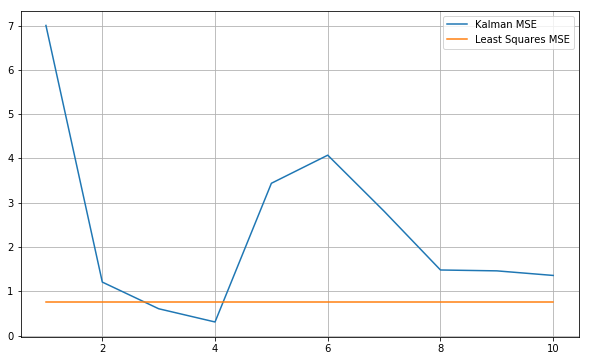

In [163]:
tgt = np.zeros(3)
n_sensors = 10
S = distribute_sensors(n_sensors,15,18)

# Noise characteristics
a = np.array([1,0,0])
b = np.array([0,1,0])
sig_a = .2
sig_b = .1

V = form_V(S,a,b,sig_a,sig_b)

y,_,mse = kalman_simple_recalc(S,V,a,b,sig_a,sig_b)
print('Kalman Solution:', y)
print('Kalman MSE:', mse[-1])
est,_ = ls_triangulate(S,V)
print('Least Squares Solution:', est)
lstsq_mse = la.norm(est)**2 / 3
print('Least Squares MSE:', lstsq_mse)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(np.linspace(1,n_sensors,n_sensors),mse,label='Kalman MSE')
ax.plot([1,n_sensors],[lstsq_mse,lstsq_mse],label='Least Squares MSE')
ax.axis('tight')
ax.grid(True)
ax.legend()

In [168]:
count1 = 0
count2 = 0
count3 = 0
for i in range(100):
    tgt = np.zeros(3)
    n_sensors = 20
    S = distribute_sensors(n_sensors,15,18)

    # Noise characteristics
    a = np.array([1,0,0])
    b = np.array([0,1,0])
    sig_a = .2
    sig_b = .1

    V = form_V(S,a,b,sig_a,sig_b)

    y,_,mse = kalman_simple_recalc(S,V,a,b,sig_a,sig_b)
    yy,_,mmse = kalman_simple(S,V,a,b,sig_a,sig_b)
    est,_ = ls_triangulate(S,V)
    lstsq_mse = la.norm(est)**2 / 3
    
    if mse[-1] <= mmse[-1]:
        count1 += 1
    if mmse[-1] <= lstsq_mse:
        count2 += 1
print(count1 / 100.0)
print(count2 / 100.0)

0.41
0.49
